# Modelo XGBoost

In [1]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
import os

In [2]:
SEED = 42
ruta_carpeta_actual = os.getcwd()
ruta_carpeta_raiz = os.path.dirname(ruta_carpeta_actual)
csv_path  = os.path.join(ruta_carpeta_raiz, "dataset", "PuntosMuestra_CR_2023.csv")
df = pd.read_csv(csv_path)

## Limpieza

In [3]:
# Eliminar CATEGORIA = 2
df_filtrado = df[df['CATEGORIA'] != 2].copy()

# Remapear categorías a consecutivas 0..K-1
clases_unicas = sorted(df_filtrado["CATEGORIA"].unique())
mapa = {old: new for new, old in enumerate(clases_unicas)}
df_filtrado["CATEGORIA"] = df_filtrado["CATEGORIA"].map(mapa)

y = df_filtrado["CATEGORIA"]
X = df_filtrado.drop(columns=["CATEGORIA", "lon", "lat", "year"])

## Definir modelo XGBoost

### Division de data test y prueba

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=y)

### Definir XGBoost utilizado

In [5]:
use_gpu = False  # True si hay CUDA y xgboost con soporte GPU

xgb = XGBClassifier(
    n_estimators=100,         # ≈ “iteraciones” (análogo a épocas)
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",  # multi-clase
    eval_metric="mlogloss",
    tree_method="gpu_hist" if use_gpu else "hist",
    device="cuda" if use_gpu else "cpu",
    n_jobs=-1,
    random_state=42
)

### Entrenamiento

In [6]:
t0 = time.perf_counter()
xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],       # útil para early_stopping
    verbose=False
)
t1 = time.perf_counter()
fit_s = t1 - t0
print(f"⏱ XGBoost – entrenamiento: {fit_s:.2f}s")

# TEST
t0 = time.perf_counter()
y_pred = xgb.predict(X_test)
t1 = time.perf_counter()
pred_s = t1 - t0
pred_ms_per_sample = (pred_s / len(y_test)) * 1000.0
print(f"⏱ XGBoost – predicción: {pred_s:.3f}s  ({pred_ms_per_sample:.2f} ms/muestra)")

⏱ XGBoost – entrenamiento: 0.60s
⏱ XGBoost – predicción: 0.007s  (0.00 ms/muestra)


### Matriz de confusion

## Metricas

In [7]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, f1_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)


oa   = accuracy_score(y_test, y_pred)
prec, rec, f1m, _ = precision_recall_fscore_support(
    y_test, y_pred, average="macro", zero_division=0
)

num_classes = len(np.unique(y_test))
cm  = confusion_matrix(y_test, y_pred, labels=list(range(num_classes)))

cm_row_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
cm_row_percentage = np.nan_to_num(cm_row_percentage)  # handle division by zero

print(f"⏱ XGBoost – entrenamiento: {fit_s:.2f}s")
print(f"⏱ XGBoost – predicción:   {pred_s:.3f}s  ({pred_ms_per_sample:.2f} ms/muestra)")
print(f"OA: {oa:.4f} | Prec(macro): {prec:.4f} | Recall(macro): {rec:.4f} | F1-macro: {f1m:.4f}")
print("Matriz de confusión (conteos):\n", cm)


⏱ XGBoost – entrenamiento: 0.60s
⏱ XGBoost – predicción:   0.007s  (0.00 ms/muestra)
OA: 0.8816 | Prec(macro): 0.8413 | Recall(macro): 0.8014 | F1-macro: 0.8200
Matriz de confusión (conteos):
 [[2222  229    0    2    0    6]
 [ 193 4252    0    7   15  101]
 [   9    1  316   10    0    0]
 [   6   14    8  268   23   35]
 [  27   54    0   11  264   56]
 [  26  138    0   20   46  401]]


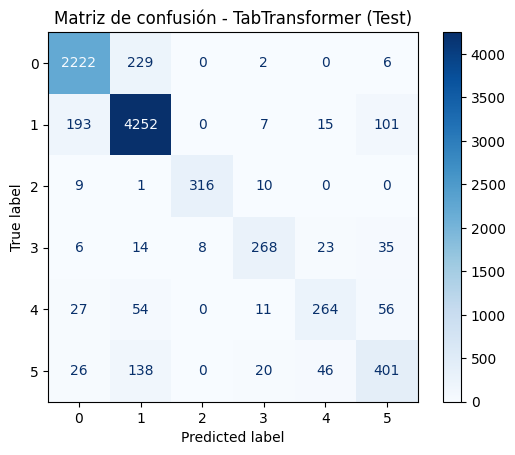

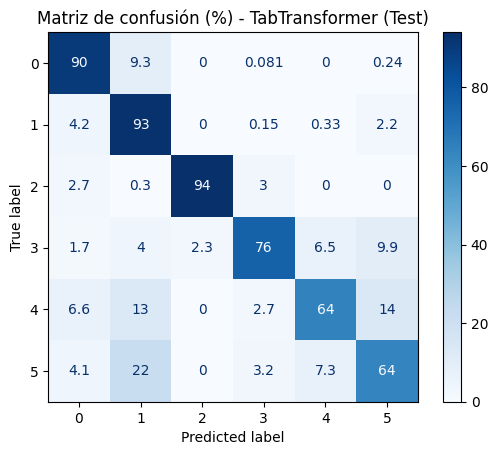

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title("Matriz de confusión - TabTransformer (Test)")
plt.show()

ConfusionMatrixDisplay(cm_row_percentage).plot(cmap='Blues')
plt.title("Matriz de confusión (%) - TabTransformer (Test)")
plt.show()

# Registrar informacion